Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from glob import glob
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.regularizers import l2

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
file_path = "/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration"
data_dir_train = pathlib.Path(file_path + '/Train')
data_dir_test = pathlib.Path(file_path + '/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [10]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

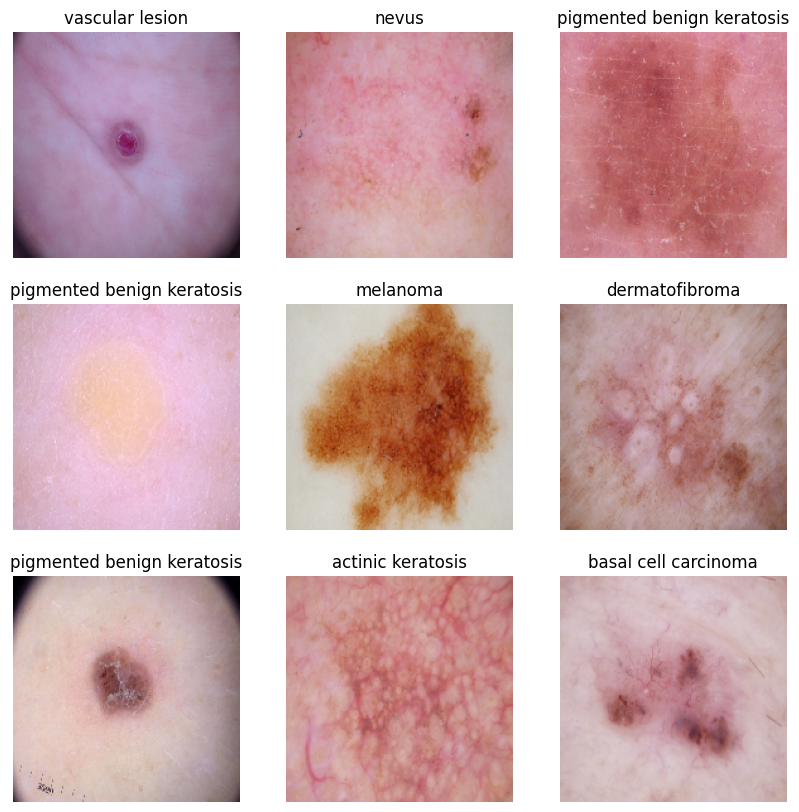

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
### Your code goes here
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

In [14]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

In [16]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

### Train the model

In [17]:
epochs = 20
batch_size = 32
history = model.fit(
  train_ds,
  validation_data=val_ds,
  batch_size=batch_size,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 171s 664ms/step - loss: 1.8831 - accuracy: 0.3036 - val_loss: 1.8033 - val_accuracy: 0.3826
Epoch 2/20
56/56 [==============================] - 2s 40ms/step - loss: 1.5526 - accuracy: 0.4481 - val_loss: 1.6968 - val_accuracy: 0.3714
Epoch 3/20
56/56 [==============================] - 2s 37ms/step - loss: 1.4684 - accuracy: 0.4782 - val_loss: 1.5162 - val_accuracy: 0.4787
Epoch 4/20
56/56 [==============================] - 2s 35ms/step - loss: 1.3401 - accuracy: 0.5229 - val_loss: 1.3703 - val_accuracy: 0.5391
Epoch 5/20
56/56 [==============================] - 2s 35ms/step - loss: 1.2612 - accuracy: 0.5530 - val_loss: 1.3483 - val_accuracy: 0.5168
Epoch 6/20
56/56 [==============================] - 2s 35ms/step - loss: 1.2014 - accuracy: 0.5608 - val_loss: 1.3902 - val_accuracy: 0.5302
Epoch 7/20
56/56 [==============================] - 2s 38ms/step - loss: 1.1786 - accuracy: 0.5658 - val_loss: 1.4194 - val_accuracy: 0.5414
Epoch 8/20

### Visualizing training results

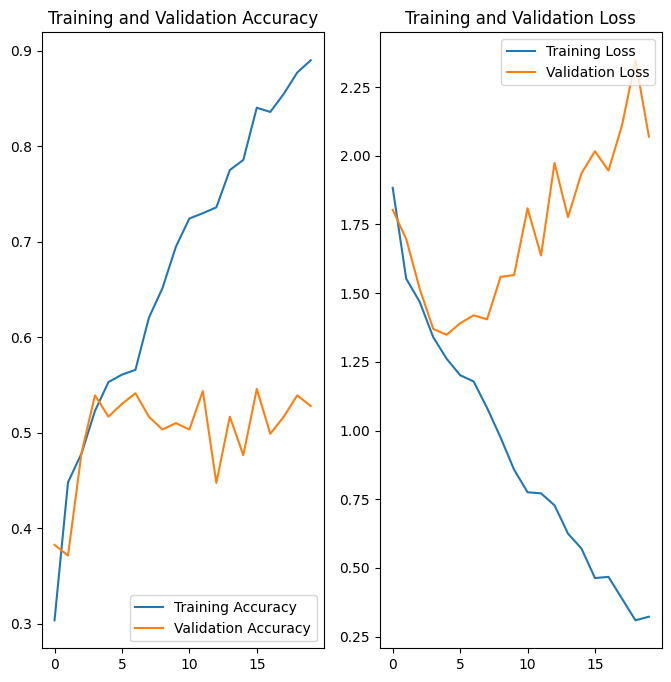

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 14ms/step - loss: 2.0696 - accuracy: 0.5280
Accuracy:  0.9224330186843872
Validation Accuracy:  0.5279642343521118
Loss:  0.22674782574176788
Validation Loss 2.0696048736572266


From the above we get to know that the model is overfit

In [21]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
    ]
)

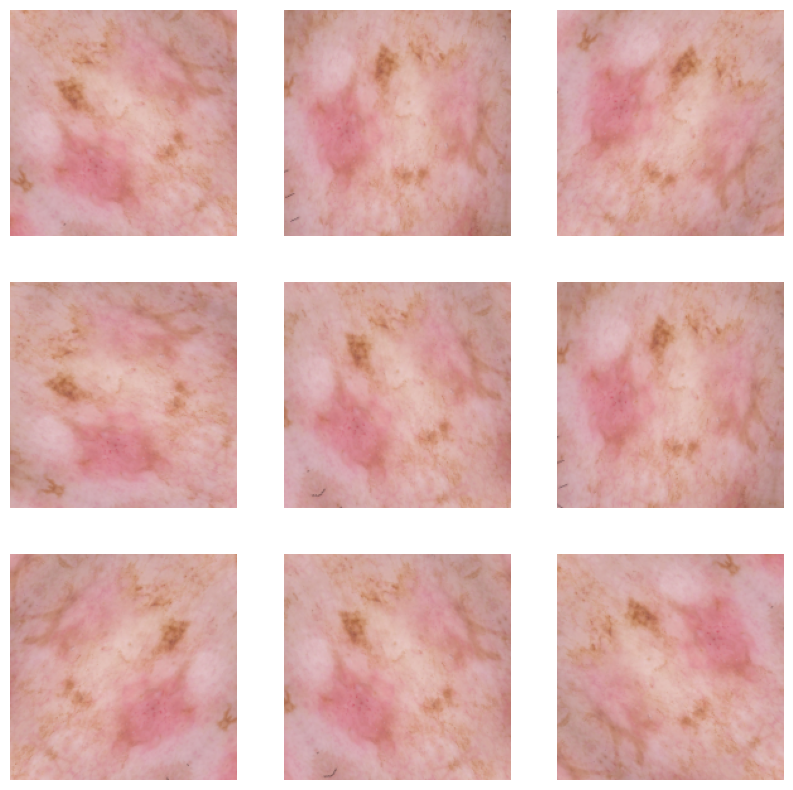

In [22]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [23]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)

Found 890 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


In [24]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(data_augmentation)
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
#model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
#model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

In [25]:
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [26]:
epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  batch_size=batch_size,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 40ms/step - loss: 1.8822 - accuracy: 0.2991 - val_loss: 1.6807 - val_accuracy: 0.4161
Epoch 2/20
56/56 [==============================] - 2s 37ms/step - loss: 1.5923 - accuracy: 0.4258 - val_loss: 1.5278 - val_accuracy: 0.4653
Epoch 3/20
56/56 [==============================] - 2s 37ms/step - loss: 1.4868 - accuracy: 0.4860 - val_loss: 1.4855 - val_accuracy: 0.4810
Epoch 4/20
56/56 [==============================] - 2s 37ms/step - loss: 1.4355 - accuracy: 0.4866 - val_loss: 1.3918 - val_accuracy: 0.5101
Epoch 5/20
56/56 [==============================] - 2s 40ms/step - loss: 1.3564 - accuracy: 0.5167 - val_loss: 1.4179 - val_accuracy: 0.5011
Epoch 6/20
56/56 [==============================] - 2s 39ms/step - loss: 1.3072 - accuracy: 0.5368 - val_loss: 1.5863 - val_accuracy: 0.4519
Epoch 7/20
56/56 [==============================] - 2s 36ms/step - loss: 1.3030 - accuracy: 0.5273 - val_loss: 1.2908 - val_accuracy: 0.5526
Epoch 8/20
56

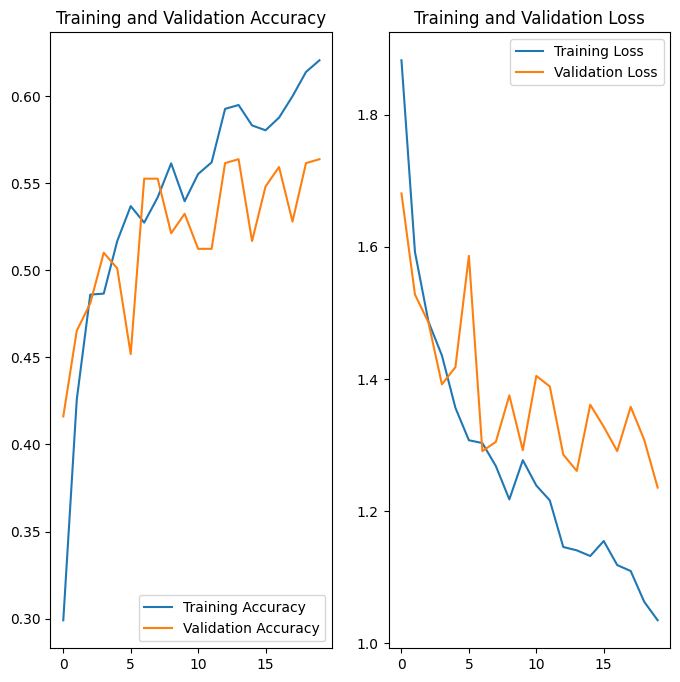

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
## Visualize distribution of classes in the training dataset.


def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,basal cell carcinoma,376
1,nevus,357
2,squamous cell carcinoma,181
3,actinic keratosis,114
4,vascular lesion,139
5,seborrheic keratosis,77
6,pigmented benign keratosis,462
7,dermatofibroma,95
8,melanoma,438


<function matplotlib.pyplot.show(close=None, block=None)>

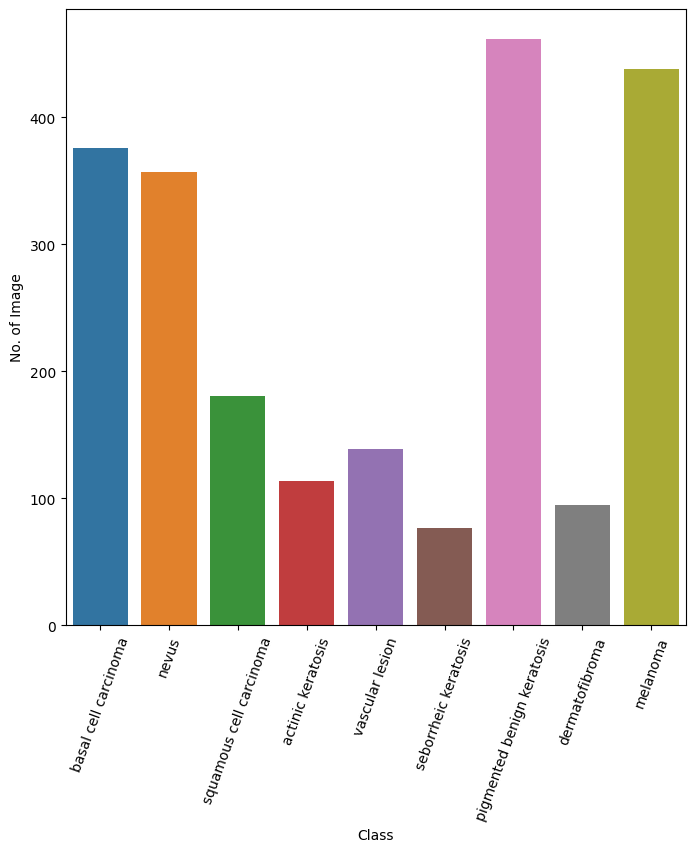

In [29]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(8, 8))
sns.barplot(x="Class", y="No. of Image", data=df,
            label="Class")
plt.xticks(rotation=70)
plt.show

The train and test accuracy is very low.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
 seborrheic keratosis has least number of samples.
#### - Which classes dominate the data in terms proportionate number of samples?
  pigmented benign keratosis, melanoma, basal cell carcinoma and nevus has maximum number of samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [30]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [31]:
path_to_training_dataset="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE268626530>: 100%|██████████| 500/500 [00:30<00:00, 16.64 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE2686263B0>: 100%|██████████| 500/500 [00:31<00:00, 16.11 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE29C6E6050>: 100%|██████████| 500/500 [00:26<00:00, 18.59 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FE268627310>: 100%|██████████| 500/500 [02:11<00:00,  3.81 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE268656920>: 100%|██████████| 500/500 [01:55<00:00,  4.32 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE2684433D0>: 100%|██████████| 500/500 [00:24<00:00, 20.77 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE2686566E0>: 100%|██████████| 500/500 [00:53<00:00,  9.42 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE268599420>: 100%|██████████| 500/500 [00:23<00:00, 21.09 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE29C6E6050>: 100%|██████████| 500/500 [00:24<00:00, 20.59 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [32]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030271.jpg_16723392-daa9-4030-9447-32be24b4f326.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026442.jpg_9a77dea7-2dd8-4555-863b-2782ed4c49ec.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031450.jpg_1aeb90ea-b537-4114-af9f-badcdfde4b40.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029082.jpg_df24aa09-466f-47ed-ac4b-94457516d889.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_

In [34]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',


In [35]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [36]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2

,Path,Label
0,/content/gdrive/MyDrive/Skin cancer ISIC The I...,basal cell carcinoma
1,/content/gdrive/MyDrive/Skin cancer ISIC The I...,basal cell carcinoma
2,/content/gdrive/MyDrive/Skin cancer ISIC The I...,basal cell carcinoma
3,/content/gdrive/MyDrive/Skin cancer ISIC The I...,basal cell carcinoma
4,/content/gdrive/MyDrive/Skin cancer ISIC The I...,basal cell carcinoma
...,...,...
4495,/content/gdrive/MyDrive/Skin cancer ISIC The I...,melanoma
4496,/content/gdrive/MyDrive/Skin cancer ISIC The I...,melanoma
4497,/content/gdrive/MyDrive/Skin cancer ISIC The I...,melanoma
4498,/content/gdrive/MyDrive/Skin cancer ISIC The I...,melanoma


In [37]:
new_df = df2

In [38]:
new_df['Label'].value_counts()

basal cell carcinoma          500
nevus                         500
squamous cell carcinoma       500
actinic keratosis             500
vascular lesion               500
seborrheic keratosis          500
pigmented benign keratosis    500
dermatofibroma                500
melanoma                      500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [39]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [40]:
data_dir_train="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                data_dir_train,
                seed=123,
                validation_split = 0.2,
                subset = "training",
                image_size=(img_height, img_width),
                batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [41]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [42]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

In [43]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [44]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

#### **Todo:**  Train your model

In [45]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/50
169/169 [==============================] - ETA: 0s - loss: 1.9036 - accuracy: 0.2604
Epoch 1: val_accuracy improved from -inf to 0.34298, saving model to model.h5
169/169 [==============================] - 48s 100ms/step - loss: 1.9036 - accuracy: 0.2604 - val_loss: 1.7208 - val_accuracy: 0.3430
Epoch 2/50
169/169 [==============================] - ETA: 0s - loss: 1.5489 - accuracy: 0.4180
Epoch 2: val_accuracy improved from 0.34298 to 0.46399, saving model to model.h5
169/169 [==============================] - 10s 57ms/step - loss: 1.5489 - accuracy: 0.4180 - val_loss: 1.4343 - val_accuracy: 0.4640
Epoch 3/50
169/169 [==============================] - ETA: 0s - loss: 1.3913 - accuracy: 0.4811
Epoch 3: val_accuracy improved from 0.46399 to 0.49592, saving model to model.h5
169/169 [==============================] - 10s 56ms/step - loss: 1.3913 - accuracy: 0.4811 - val_loss: 1.3522 - val_accuracy: 0.4959
Epoch 4/50
169/169 [==============================] - ETA: 0s - loss: 1.

#### **Todo:**  Visualize the model results

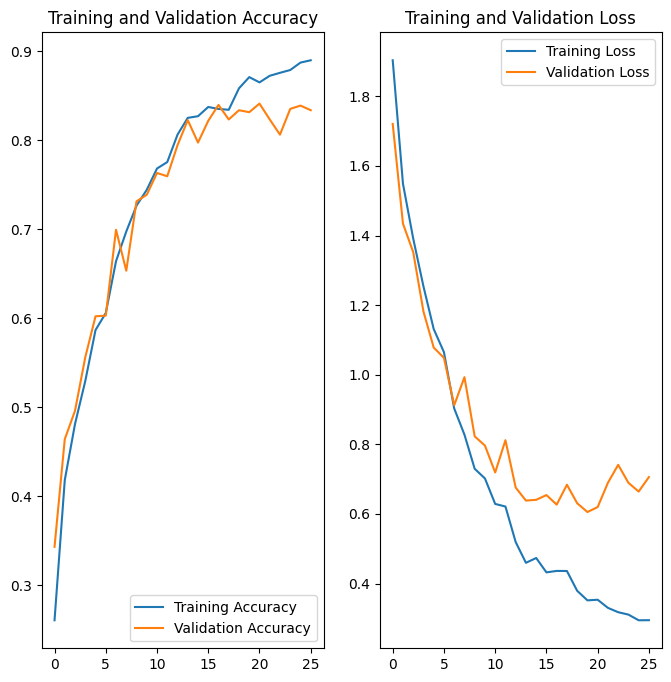

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Yes the overfitting and underfitting has been taken care by rebalancing.

1/1 [==============================] - 0s 271ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


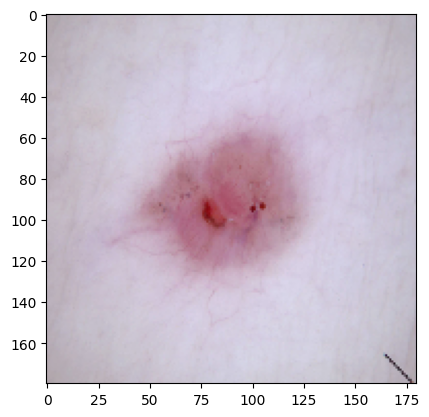

In [47]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )